# Regression for the Petite Couronne region

Correlation doesnt require any sort of regression. Then we just want to find a fine predictor.

We investigate the correlation between the aggregated 2SFCA score and mean income in the Petite Couronne region

In [193]:
gdf_name = "results_pcparis.gpkg" 

In [194]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
os.environ['USE_PYGEOS'] = '0'
import pysal.lib
import helpers as hs
from importlib import reload
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [195]:
%cd ../data
gdf = gpd.read_file(gdf_name, layer="cool")

/Users/marcel/prl/BATO-MOUCHE-Extension-Continued/data


In [196]:
gdf["mean_income"] = gdf["Ind_snv"]/gdf["Ind"]

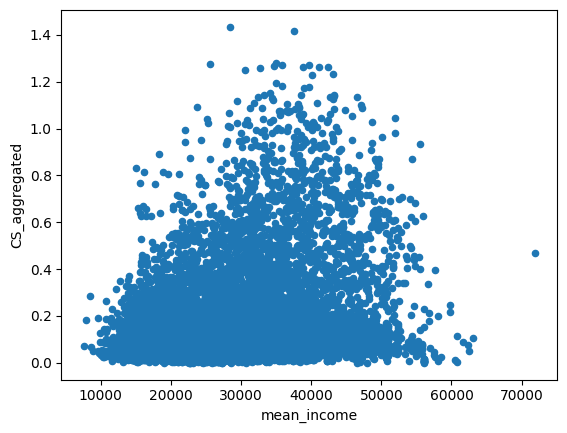

In [197]:
gdf.plot(x='mean_income',y='CS_aggregated', kind='scatter')
plt.show()

We see that there is a disproportionate amount of extremely low accessibility scores. Therefore, we transform the y axis to logscale:

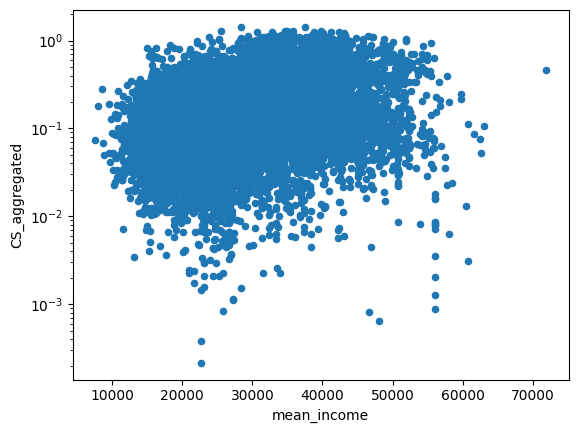

In [198]:
gdf.plot(x='mean_income',y='CS_aggregated', kind='scatter')
plt.yscale("log")
plt.show()

Now we begin to see some trend lines. On this log transformed data, we can perform linear regression:from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = gdfs["mean_income"].values
y = gdfs["CS_aggregated"].values
x = x.reshape(-1,1)
yr = y.reshape(-1,1)

yr = yr + 0.0001
yr = np.log(yr)



model = LinearRegression()
model.fit(x, yr)

yr_pred = model.predict(x)

plt.scatter(x, yr, color='blue', label='Actual Data')
plt.plot(x, yr_pred, color='red', label='Fitted Line')
plt.xlabel('Log of Mean Income')
plt.ylabel('Log of CS Aggregated')
plt.legend()
plt.title('Log-Transformed Linear Regression')
plt.show()

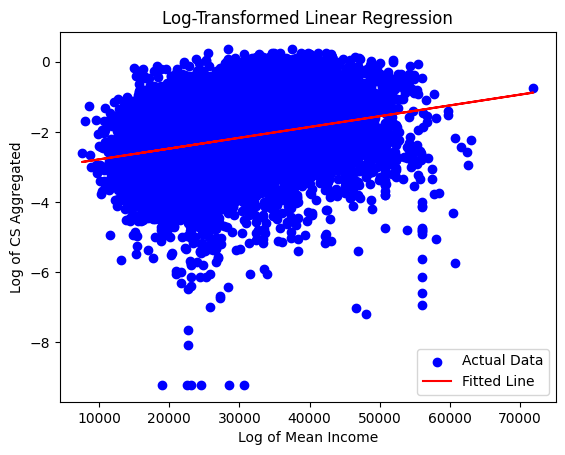

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = gdf["mean_income"].values
y = gdf["CS_aggregated"].values
x = x.reshape(-1,1)
yr = y.reshape(-1,1)

yr = yr + 0.0001
yr = np.log(yr)

model = LinearRegression()
model.fit(x, yr)

yr_pred = model.predict(x)

plt.scatter(x, yr, color='blue', label='Actual Data')
plt.plot(x, yr_pred, color='red', label='Fitted Line')
plt.xlabel('Log of Mean Income')
plt.ylabel('Log of CS Aggregated')
plt.legend()
plt.title('Log-Transformed Linear Regression')
plt.show()

There is a large amount of outliers still with extremely low CS aggregated score. This may result from a large amount of squares being on the edge of the considered area. As the bounds of the surveyed area are quite rough, those outliers might happen and it makes sense to remove them.

In [200]:
threshold = gdf['CS_aggregated'].quantile(0.01)
outliers = gdf[gdf['CS_aggregated'] < threshold]
remaining = gdf[gdf['CS_aggregated'] >= threshold]

income_threshold = remaining['mean_income'].quantile(0.999)
rem2 = remaining[remaining['mean_income'] < income_threshold]

In [201]:
outliers.explore()

0.7134548030039533


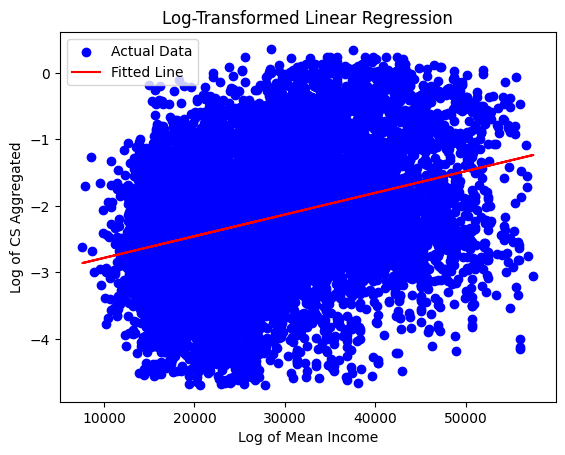

In [202]:

x = rem2["mean_income"].values
y = rem2["CS_aggregated"].values
x = x.reshape(-1,1)
yr = y.reshape(-1,1)

yr = yr + 0.0001
yr = np.log(yr)

model = LinearRegression()
model.fit(x, yr)

yr_pred = model.predict(x)

print(mean_squared_error(yr, yr_pred))

plt.scatter(x, yr, color='blue', label='Actual Data')
plt.plot(x, yr_pred, color='red', label='Fitted Line')
plt.xlabel('Log of Mean Income')
plt.ylabel('Log of CS Aggregated')
plt.legend()
plt.title('Log-Transformed Linear Regression')
plt.show()

Clear tend, but with a huge variance.

Why *not* remove the outleirs? - rich people often choose to live in inaccessible places.

Regression with more vars:

In [203]:
gdf.describe()

,I_est_cr,Groupe,I_pauv,Ind,Men,Men_pauv,Men_1ind,Men_5ind,Men_prop,Men_fmp,...,weight_supply_shops,restaurant_access_normalized,culture and art_access_normalized,education_access_normalized,food_shops_access_normalized,fashion_beauty_access_normalized,supply_shops_access_normalized,CS_aggregated,CS_aggregated_without_weight,mean_income
count,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,...,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000
mean,0.116388,854732.166691,0.000144,479.322247,205.001081,31.535370,80.196671,18.579454,80.988649,23.305275,...,0.207935,0.090897,0.009295,0.026938,0.017436,0.013880,0.049890,0.160541,0.208336,26847.493091
std,0.320701,46483.258460,0.012005,490.401087,230.643809,42.708761,114.235530,21.694428,89.793282,26.859769,...,0.000000,0.121109,0.018192,0.019771,0.018388,0.025532,0.059697,0.177335,0.236468,9036.676639
min,0.000000,149891.000000,0.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.207935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7598.839902
25%,0.000000,848900.750000,0.000000,142.000000,52.225000,4.000000,11.000000,5.000000,18.000000,4.000000,...,0.207935,0.024484,0.002566,0.014275,0.006498,0.002122,0.013664,0.059335,0.073868,19883.027652
50%,0.000000,858837.500000,0.000000,307.500000,120.000000,15.000000,35.000000,12.000000,56.000000,13.000000,...,0.207935,0.048005,0.005103,0.023858,0.012154,0.005276,0.028885,0.100594,0.127585,25198.693853
75%,0.000000,866719.250000,0.000000,657.500000,272.000000,43.000000,98.000000,24.000000,105.000000,34.000000,...,0.207935,0.099056,0.010067,0.035855,0.022024,0.013130,0.059624,0.181843,0.235129,32347.371291
max,1.000000,884220.000000,1.000000,4033.500000,1546.000000,425.000000,864.000000,289.000000,664.000000,219.000000,...,0.207935,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.434452,1.920779,71896.193333


In [204]:
import seaborn as sns

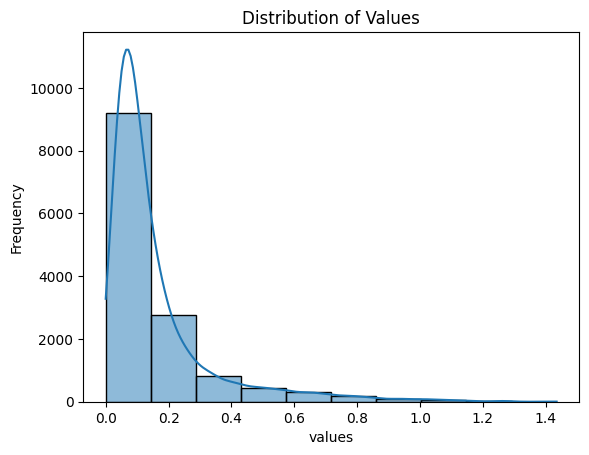

In [205]:
# Plot distribution
sns.histplot(gdf['CS_aggregated'], kde=True, bins=10)  # kde=True adds a kernel density estimate curve
plt.title('Distribution of Values')
plt.xlabel('values')
plt.ylabel('Frequency')
plt.show()

In [206]:
gdf["CSlog"] = np.log(gdf["CS_aggregated"] + 0.00001)

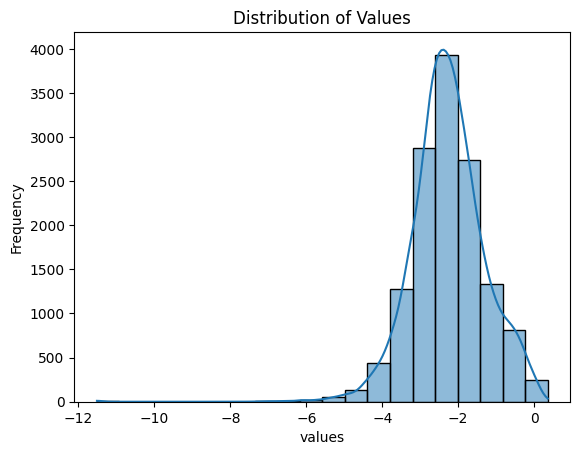

In [207]:
# Plot distribution
sns.histplot(gdf['CSlog'], kde=True, bins=20)  # kde=True adds a kernel density estimate curve
plt.title('Distribution of Values')
plt.xlabel('values')
plt.ylabel('Frequency')
plt.show()

we can see a ton of outliers!

In [208]:
rem2["CSlog"] = np.log(rem2["CS_aggregated"] + 0.00001)

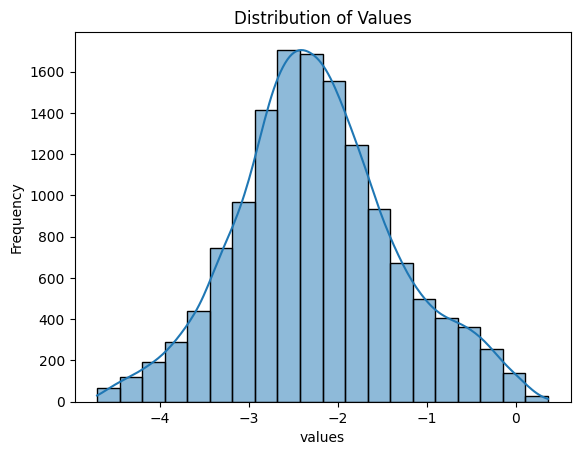

In [209]:
# Plot distribution
sns.histplot(rem2['CSlog'], kde=True, bins=20)  # kde=True adds a kernel density estimate curve
plt.title('Distribution of Values')
plt.xlabel('values')
plt.ylabel('Frequency')
plt.show()

Looking good, almost normal!

In [210]:
gdfs = rem2.copy()
gdfs["%_soc.minimum"] = (gdfs["Men_pauv"]/gdfs["Ind"])*100
gdfs["%_>_65"] = ((gdfs["Ind_65_79"] +gdfs["Ind_80p"])/gdfs["Ind"])*100
gdfs["%_<_17"] = ((gdfs["Ind_0_3"] +gdfs["Ind_4_5"] + gdfs["Ind_6_10"] + gdfs["Ind_11_17"])/gdfs["Ind"])*100
gdfs["%_<_bat_45"] = (gdfs["Log_av45"]/(gdfs["Log_av45"] +gdfs["Log_45_70"] + gdfs["Log_70_90"] + gdfs["Log_ap90"] + gdfs["Log_inc"]))*100
gdfs["%_>_bat_90"] = (gdfs["Log_ap90"]/(gdfs["Log_av45"] +gdfs["Log_45_70"] + gdfs["Log_70_90"] + gdfs["Log_ap90"] + gdfs["Log_inc"]))*100
gdfs["%_residences"] = (gdfs["Men_coll"]/(gdfs["Men_coll"] +gdfs["Men_mais"]))*100
gdfs["mean_income"] = gdfs["Ind_snv"]/gdfs["Ind"]
gdfs["density"] = gdfs["Ind"]/(0.0002)

In [211]:
gdfs.describe()

,I_est_cr,Groupe,I_pauv,Ind,Men,Men_pauv,Men_1ind,Men_5ind,Men_prop,Men_fmp,...,CS_aggregated_without_weight,mean_income,CSlog,%_soc.minimum,%_>_65,%_<_17,%_<_bat_45,%_>_bat_90,%_residences,density
count,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,...,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,1.372300e+04
mean,0.112002,855371.965532,0.000146,483.863951,207.002922,31.846637,81.022961,18.747635,81.698411,23.536078,...,0.210400,26789.892232,-2.235435,5.677920,14.701753,23.516925,32.995667,23.785495,65.378293,2.419320e+06
std,0.315380,42379.259884,0.012072,491.106329,231.107501,42.830654,114.593153,21.747807,90.008421,26.913255,...,0.236831,8951.137536,0.894743,4.076773,6.852840,6.232511,28.824067,26.007565,35.731918,2.455532e+06
min,0.000000,149891.000000,0.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010196,7598.839902,-4.702067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+03
25%,0.000000,848925.500000,0.000000,147.500000,54.000000,4.000000,12.000000,5.000000,19.000000,4.000000,...,0.075238,19860.003711,-2.808853,2.857143,10.132330,19.480519,6.250000,4.733619,31.501456,7.375000e+05
50%,0.000000,858832.000000,0.000000,312.000000,122.000000,15.000000,36.000000,12.000000,57.000000,13.000000,...,0.128961,25171.735025,-2.284615,5.013928,14.168040,23.250000,27.102804,14.509804,81.250000,1.560000e+06
75%,0.000000,866735.500000,0.000000,663.250000,275.000000,44.000000,99.000000,25.000000,105.000000,34.000000,...,0.237020,32312.419436,-1.694660,7.716136,18.625466,27.480916,54.545455,33.314329,97.435897,3.316250e+06
max,1.000000,884220.000000,1.000000,4033.500000,1546.000000,425.000000,864.000000,289.000000,664.000000,219.000000,...,1.920779,57448.054286,0.360790,51.063830,86.250000,55.744681,100.000000,100.000000,100.000000,2.016750e+07


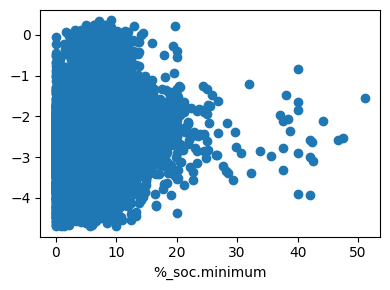

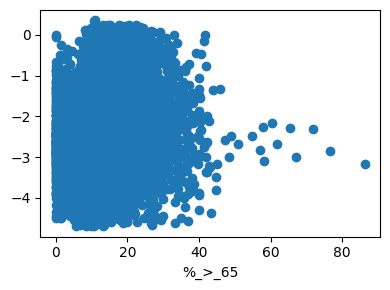

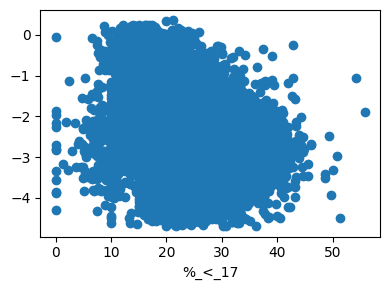

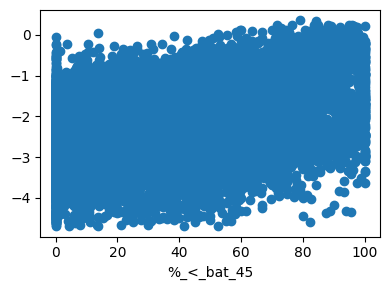

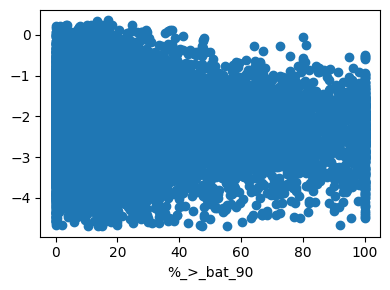

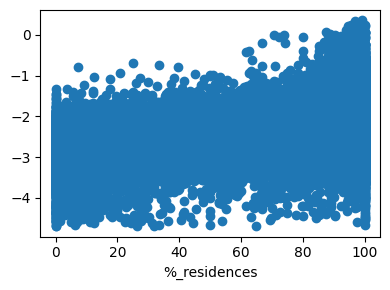

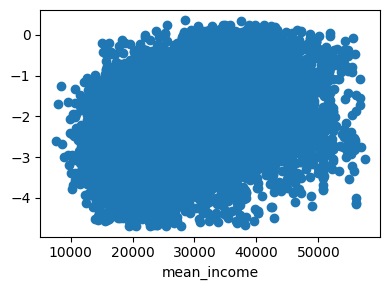

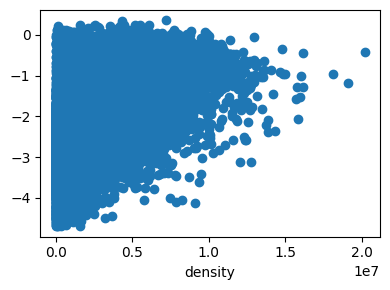

In [212]:
soc_vars = ["%_soc.minimum", "%_>_65", "%_<_17", "%_<_bat_45", "%_>_bat_90", "%_residences", "mean_income","density"]
for feature in soc_vars:
    plt.figure(figsize=(4, 3))
    plt.scatter(gdfs[feature].values, gdfs["CSlog"])
    plt.xlabel(feature)
    plt.tight_layout()

Okay. We will just do linear regression on: density, mean income, residences, bat90, bat45. Let's see how correlated they are.

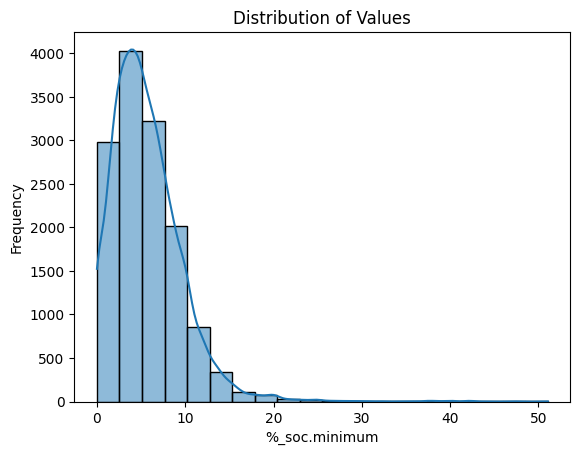

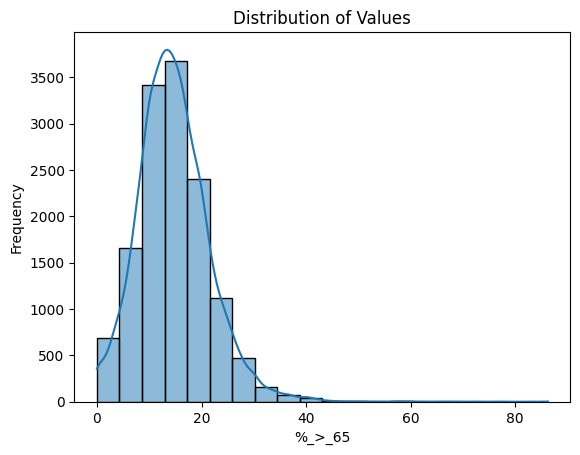

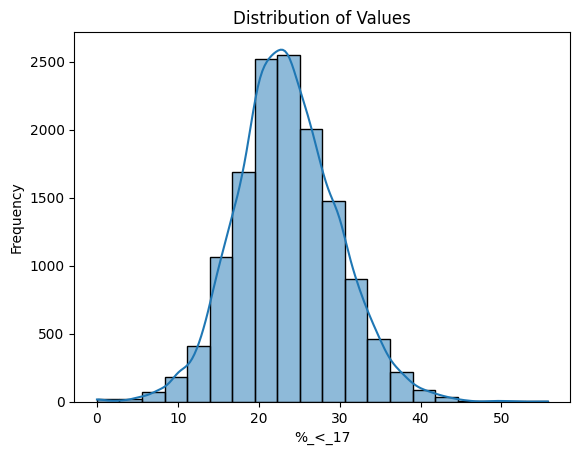

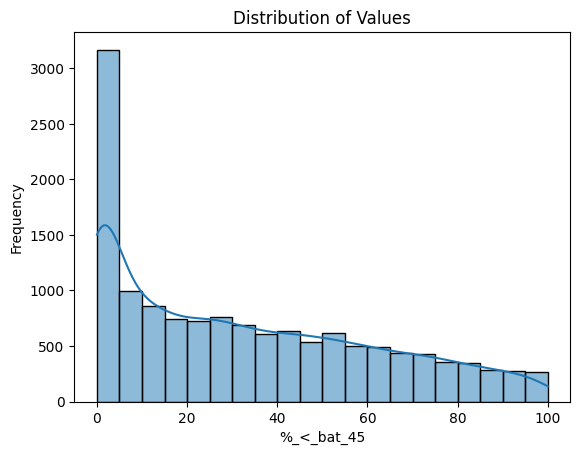

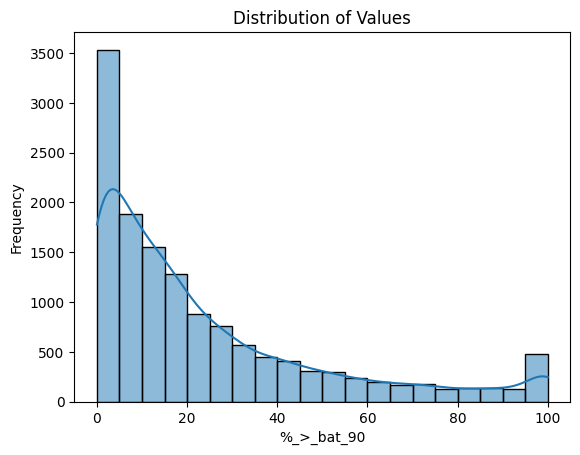

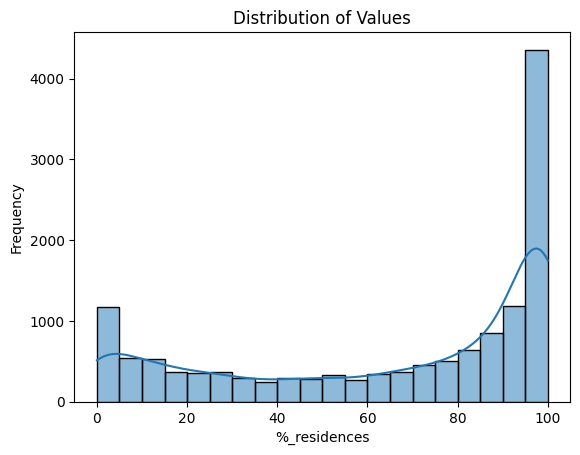

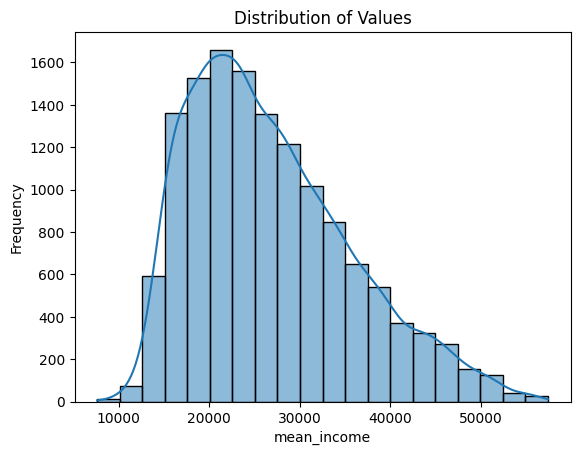

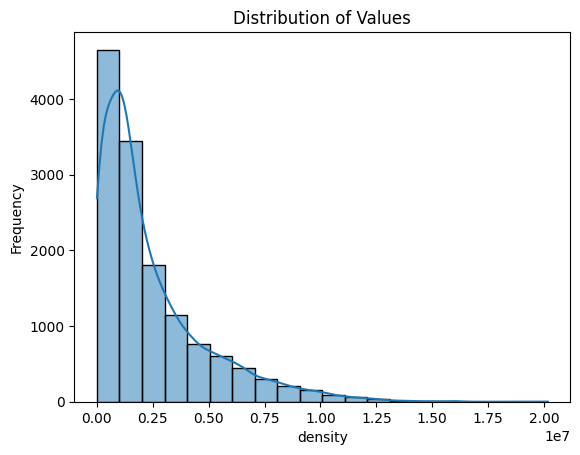

In [213]:
soc_vars = ["%_soc.minimum", "%_>_65", "%_<_17", "%_<_bat_45", "%_>_bat_90", "%_residences", "mean_income","density"]
for feature in soc_vars:
    sns.histplot(gdfs[feature], kde=True, bins=20)  # kde=True adds a kernel density estimate curve
    plt.title('Distribution of Values')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [215]:
gdfs[soc_vars].describe()

,%_soc.minimum,%_>_65,%_<_17,%_<_bat_45,%_>_bat_90,%_residences,mean_income,density
count,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,1.372300e+04
mean,5.677920,14.701753,23.516925,32.995667,23.785495,65.378293,26789.892232,2.419320e+06
std,4.076773,6.852840,6.232511,28.824067,26.007565,35.731918,8951.137536,2.455532e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7598.839902,5.000000e+03
25%,2.857143,10.132330,19.480519,6.250000,4.733619,31.501456,19860.003711,7.375000e+05
50%,5.013928,14.168040,23.250000,27.102804,14.509804,81.250000,25171.735025,1.560000e+06
75%,7.716136,18.625466,27.480916,54.545455,33.314329,97.435897,32312.419436,3.316250e+06
max,51.063830,86.250000,55.744681,100.000000,100.000000,100.000000,57448.054286,2.016750e+07


Correlation Matrix:
              %_<_bat_45  %_>_bat_90  %_residences  mean_income   density
%_<_bat_45      1.000000   -0.363555     -0.062445     0.281152  0.056848
%_>_bat_90     -0.363555    1.000000      0.127089    -0.094413 -0.007652
%_residences   -0.062445    0.127089      1.000000    -0.123215  0.553547
mean_income     0.281152   -0.094413     -0.123215     1.000000 -0.022120
density         0.056848   -0.007652      0.553547    -0.022120  1.000000


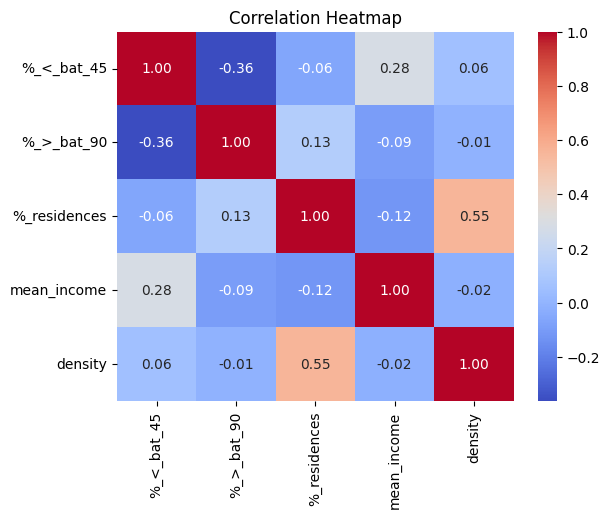

VIF Scores:
        Feature       VIF
0    %_<_bat_45  2.774935
1    %_>_bat_90  1.979661
2  %_residences  5.202114
3   mean_income  4.978423
4       density  2.882637


In [223]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
soc_vars = ["%_<_bat_45", "%_>_bat_90", "%_residences", "mean_income","density"]

gdfrel = gdfs[soc_vars]
correlation_matrix = gdfrel.corr()
print("Correlation Matrix:")
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

X = gdfrel  # Independent variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Scores:")
print(vif_data)

Generally, we get a semi-worrying correlation between density and number of residences. This someone violates the assumptions of linear regressions, but since it is one mutlicolinearity, we shall allow it.

In [234]:
socvars = ["density", "%_>_bat_90", "%_<_bat_45", "%_soc.minimum", "%_residences", "mean_income"]
import statsmodels.api as sm

X = gdfs[socvars]  
X = sm.add_constant(X)  
y = gdfs['CSlog']  

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CSlog   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     2863.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:43:58   Log-Likelihood:                -12374.
No. Observations:               13723   AIC:                         2.476e+04
Df Residuals:                   13716   BIC:                         2.481e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.3550      0.026   -168.449

# Spatial regression recreated

In [105]:
from pysal.model import spreg
from pysal.lib import weights
from spreg import OLS

In [117]:
gdfs = gdf.copy()

In [118]:
gdfs["%_soc.minimum"] = (gdfs["Men_pauv"]/gdfs["Ind"])*100
gdfs["%_>_65"] = ((gdfs["Ind_65_79"] +gdfs["Ind_80p"])/gdfs["Ind"])*100
gdfs["%_<_17"] = ((gdfs["Ind_0_3"] +gdfs["Ind_4_5"] + gdfs["Ind_6_10"] + gdfs["Ind_11_17"])/gdfs["Ind"])*100
gdfs["%_<_bat_45"] = (gdfs["Log_av45"]/(gdfs["Log_av45"] +gdfs["Log_45_70"] + gdfs["Log_70_90"] + gdfs["Log_ap90"] + gdfs["Log_inc"]))*100
gdfs["%_>_bat_90"] = (gdfs["Log_ap90"]/(gdfs["Log_av45"] +gdfs["Log_45_70"] + gdfs["Log_70_90"] + gdfs["Log_ap90"] + gdfs["Log_inc"]))*100
gdfs["%_residences"] = (gdfs["Men_coll"]/(gdfs["Men_coll"] +gdfs["Men_mais"]))*100
gdfs["mean_income"] = gdfs["Ind_snv"]/gdfs["Ind"]
gdfs["density"] = gdfs["Ind"]/(0.0002)

In [119]:
w_queen = weights.contiguity.Queen.from_dataframe(gdfs) # adjacent in all directions, including diagonal.
# Replace Queen by rook for only up/down/left/right adjancy

In [109]:
w_queen.transform = 'r'

('WARNING: ', 196, ' is an island (no neighbors)')
('WARNING: ', 231, ' is an island (no neighbors)')
('WARNING: ', 744, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 813, ' is an island (no neighbors)')
('WARNING: ', 823, ' is an island (no neighbors)')
('WARNING: ', 836, ' is an island (no neighbors)')
('WARNING: ', 841, ' is an island (no neighbors)')
('WARNING: ', 862, ' is an island (no neighbors)')
('WARNING: ', 1020, ' is an island (no neighbors)')
('WARNING: ', 1060, ' is an island (no neighbors)')
('WARNING: ', 1063, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1259, ' is an island (no neighbors)')
('WARNING: ', 1754, ' is an island (no neighbors)')
('WARNING: ', 1766, ' is an island (no neighbors)')
('WARNING: ', 1769, ' is an island (no neighbors)')
('WARNING: ', 1779, ' is an island (no neighbors)')
('WARNING: ', 1781, ' is an island (no neighbors)')
('WARNING: ', 2437, '

Model B:

In [93]:
dep_var = "CS_aggregated"
independ_var_B = ["%_soc.minimum", "%_>_65", "%_<_17", "%_<_bat_45", "%_>_bat_90", "%_residences", "mean_income","density"]
ols = OLS(gdfs[[dep_var]].values, gdfs[independ_var_B].values)

In [83]:
sample = gdfs[independ_var_B]
sample.describe()

,%_soc.minimum,%_>_65,%_<_17,%_<_bat_45,%_>_bat_90,%_residences,mean_income,density
count,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,13876.000000,1.387600e+04
mean,5.656718,14.726085,23.511663,32.902895,23.734305,64.919831,26847.493091,2.396611e+06
std,4.079000,6.873213,6.238044,28.823833,25.956499,35.945342,9036.676639,2.452005e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7598.839902,5.000000e+03
25%,2.846613,10.134793,19.480519,6.246520,4.706895,30.303030,19883.027652,7.100000e+05
50%,5.000000,14.193357,23.257494,26.966292,14.528471,80.706960,25198.693853,1.537500e+06
75%,7.694937,18.656716,27.473474,54.466100,33.167904,97.368421,32347.371291,3.287500e+06
max,51.063830,86.250000,55.744681,100.000000,100.000000,100.000000,71896.193333,2.016750e+07


The density and mean income being distributed differently pose an issue. Therefore, we redistribute them (just for interpretability).

In [120]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
changevars = independ_var_B
gdfs[changevars] = scaler.fit_transform(gdfs[changevars])
gdfs["CS_aggregated"] += 0.0000001

In [123]:
gdfs["CS_aggregated"] = scaler.fit_transform(gdfs[["CS_aggregated"]])

In [124]:
mB = spreg.GM_Combo(
    gdfs[[dep_var]].values,
    gdfs[independ_var_B].values,
    w=w_queen,
    name_y=dep_var,
    name_x=independ_var_B,
)

print(mB.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :CS_aggregated                Number of Observations:       13876
Mean dependent var  :      0.1119                Number of Variables   :          10
S.D. dependent var  :      0.1236                Degrees of Freedom    :       13866
Pseudo R-squared    :      0.8954
Spatial Pseudo R-squared:  0.5888

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.00161         0.00337         0.47847         0.63231
       %_soc.minimum         0.00844         0.00633         1.33275         0.18261
              %_>_65   

In [114]:
mB = spreg.GM_Combo(
    gdfs[[dep_var]].values,
    gdfs[independ_var_B].values,
    w=w_queen,
    name_y=dep_var,
    name_x=independ_var_B,
)

print(mB.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS - GM-COMBO MODEL
-----------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :CS_aggregated                Number of Observations:       13876
Mean dependent var  :     -0.0000                Number of Variables   :          10
S.D. dependent var  :      1.0000                Degrees of Freedom    :       13866
Pseudo R-squared    :      0.9096
Spatial Pseudo R-squared:  0.5866

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.00623         0.00224        -2.78760         0.00531
       %_soc.minimum        -0.00627         0.00352        -1.78015         0.07505
              %_>_65   

In [116]:
m1 = spreg.OLS(
    gdfs[[dep_var]].values,
    gdfs[independ_var_B].values,
    name_y=dep_var,
    name_x=independ_var_B,
)

print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :CS_aggregated                Number of Observations:       13876
Mean dependent var  :     -0.0000                Number of Variables   :           9
S.D. dependent var  :      1.0000                Degrees of Freedom    :       13867
R-squared           :      0.5300
Adjusted R-squared  :      0.5298
Sum squared residual:      6521.3                F-statistic           :   1954.8918
Sigma-square        :       0.470                Prob(F-statistic)     :           0
S.E. of regression  :       0.686                Log likelihood        :  -14450.403
Sigma-square ML     :       0.470                Akaike info criterion :   28918.805
S.E of regression ML:      0.6855                Schwarz criterion     :   28986.647

-----------------------------------------------------------

In [115]:
allvars = independ_var_B + ["CS_aggregated"]
allvar = gdfs[allvars]
allvar.describe()

,%_soc.minimum,%_>_65,%_<_17,%_<_bat_45,%_>_bat_90,%_residences,mean_income,density,CS_aggregated
count,1.387600e+04,1.387600e+04,1.387600e+04,1.387600e+04,13876.000000,1.387600e+04,1.387600e+04,1.387600e+04,1.387600e+04
mean,1.638611e-17,3.482049e-16,-3.932667e-16,-6.554444e-17,0.000000,1.638611e-17,-3.932667e-16,6.554444e-17,-9.831667e-17
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-1.386840e+00,-2.142610e+00,-3.769212e+00,-1.141558e+00,-0.914421,-1.806136e+00,-2.130136e+00,-9.754046e-01,-9.053335e-01
25%,-6.889447e-01,-6.680220e-01,-6.462423e-01,-9.248366e-01,-0.733076,-9.630747e-01,-7.707166e-01,-6.878745e-01,-5.707260e-01
50%,-1.610055e-01,-7.751068e-02,-4.074636e-02,-2.059690e-01,-0.354677,4.392140e-01,-1.824629e-01,-3.503835e-01,-3.380592e-01
75%,4.997039e-01,5.718974e-01,6.351276e-01,7.481303e-01,0.363452,9.027528e-01,6.086393e-01,3.633438e-01,1.201278e-01
max,1.113232e+01,1.040656e+01,5.167354e+00,2.327918e+00,2.938318,9.759661e-01,4.985276e+00,7.247753e+00,7.183918e+00
